# Download and Sort Data

In [ ]:
#Download data
! kaggle datasets download 'ninadaithal/imagesoasis'
! unzip imagesoasis.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Define root directory
root_dir = "/content/Data"

# Initialize containers
data = []
labels = []
patient_scan_to_files = defaultdict(list)

# Parse the directory structure
class_dirs = os.listdir(root_dir)
for class_label, class_dir in enumerate(class_dirs):
    class_path = os.path.join(root_dir, class_dir)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                # Extract patient ID (e.g., "0362") and scan number (e.g., "MR1") from the file name
                parts = filename.split("_")
                patient_id = parts[1]
                scan_no = parts[2]
                patient_scan_id = f"{patient_id}_{scan_no}"  # Combine patient ID and scan number

                # Append the patient_scan_id, label, and file path
                data.append((patient_scan_id, class_label, os.path.join(class_path, filename)))
                patient_scan_to_files[patient_scan_id].append((class_label, os.path.join(class_path, filename)))

# Extract unique patient_scan_ids and their labels
unique_patient_scan_ids = list(patient_scan_to_files.keys())
unique_labels = [patient_scan_to_files[psid][0][0] for psid in unique_patient_scan_ids]  # All files for a scan have the same label

# Split into train/validation and test sets (20% test)
train_val_ids, test_ids, train_val_labels, test_labels = train_test_split(
    unique_patient_scan_ids, unique_labels, test_size=0.2, stratify=unique_labels, random_state=42
)

# Collect file paths and labels for the test set
test_files = []
test_labels_list = []
for psid in test_ids:
    for file_info in patient_scan_to_files[psid]:
        test_files.append(file_info[1])
        test_labels_list.append(file_info[0])

# Split train/validation into separate training and validation sets (e.g., 80% train, 20% validation)
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_val_ids, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42
)

# Collect file paths and labels for the training and validation sets
train_files = []
train_labels_list = []
val_files = []
val_labels_list = []

for psid in train_ids:
    for file_info in patient_scan_to_files[psid]:
        train_files.append(file_info[1])
        train_labels_list.append(file_info[0])

for psid in val_ids:
    for file_info in patient_scan_to_files[psid]:
        val_files.append(file_info[1])
        val_labels_list.append(file_info[0])

# Output results
print(f"Test set size: {len(test_files)} files, {len(test_labels_list)} labels")
print(f"Train set size: {len(train_files)} files, {len(train_labels_list)} labels")
print(f"Validation set size: {len(val_files)} files, {len(val_labels_list)} labels")


Test set size: 17568 files, 17568 labels
Train set size: 55144 files, 55144 labels
Validation set size: 13725 files, 13725 labels


In [ ]:
#Working to test stuff out
def count_substring_in_list(strings, substring):
    return sum(string.count(substring) for string in strings)

print(count_substring_in_list(train_files, '0362'))
print(count_substring_in_list(val_files, '0362'))
print(count_substring_in_list(test_files, '0362'))

244
0
0


In [ ]:
#Set Device
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
from google.colab import drive
drive.mount('/content/drive')

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Mounted at /content/drive
Device: cuda


In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define target size and transform
target_size = (248, 496) # original image size
transform = transforms.Compose([
    # Resize images to target size
    transforms.Resize(target_size),

    # Convert images to tensors
    transforms.ToTensor(),

    # Normalize with ImageNet mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class to handle paths and labels
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image and apply transform
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


# Create datasets
train_dataset = ImageDataset(train_files, train_labels_list, transform=transform)
valid_dataset = ImageDataset(val_files, val_labels_list, transform=transform)
test_dataset = ImageDataset(test_files, test_labels_list, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Example usage
img, label = train_dataset[0]
print("Image shape:", img.shape)
print("Label:", label)


Image shape: torch.Size([3, 248, 496])
Label: 2


# Train MobileNet Model

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='model', epochs=20):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')

        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()


            # Run the model on the input data and compute the outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_module(outputs, labels)

            # Perform backpropagation
            loss.backward()


            # Update the parameters
            optimizer.step()

            # Calculate the loss for current iteration
            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')

        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), f"/content/drive/My Drive/Colab Notebooks/epoch{epoch+1}.pth")


        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


Epoch 1/20, Train Loss: 0.2465,  Valid Loss: 0.9498


Epoch 2/20, Train Loss: 0.0168,  Valid Loss: 0.9746


Epoch 3/20, Train Loss: 0.0064,  Valid Loss: 1.1811


Epoch 4/20, Train Loss: 0.0048,  Valid Loss: 1.1303


Epoch 5/20, Train Loss: 0.0044,  Valid Loss: 1.3708


Epoch 6/20, Train Loss: 0.0040,  Valid Loss: 1.7530


Epoch 7/20, Train Loss: 0.0024,  Valid Loss: 1.1870


Epoch 8/20, Train Loss: 0.0033,  Valid Loss: 1.2548


Epoch 9/20, Train Loss: 0.0042,  Valid Loss: 1.6028


Epoch 10/20, Train Loss: 0.0024,  Valid Loss: 1.2976


Epoch 11/20, Train Loss: 0.0025,  Valid Loss: 1.4252


Epoch 12/20, Train Loss: 0.0016,  Valid Loss: 1.5878


Epoch 13/20, Train Loss: 0.0042,  Valid Loss: 1.3747


Epoch 14/20, Train Loss: 0.0012,  Valid Loss: 1.3197


Epoch 15/20, Train Loss: 0.0003,  Valid Loss: 1.3974


Epoch 16/20, Train Loss: 0.0000,  Valid Loss: 1.4926


Epoch 17/20, Train Loss: 0.0000,  Valid Loss: 1.4408


Epoch 18/20, Train Loss: 0.0048,  Valid Loss: 1.3432


Epoch 19/20, Train Loss: 0.0011,  Valid Loss: 1.7452


Epoch 20/20, Train Loss: 0.0028,  Valid Loss: 1.6769


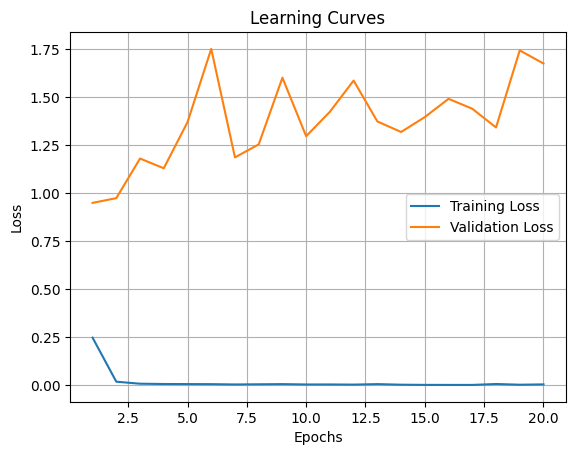

In [ ]:
# Load pretrained MobileNet model with default weights
weights = MobileNet_V2_Weights.DEFAULT
mobilenet = mobilenet_v2(weights=weights)

# Define the number of classes in your dataset
num_classes = 4  # Update for 4 classes

# Retrieve the feature map size going into the classifier
in_features = mobilenet.classifier[1].in_features

# Replace the last layer of the classifier with a new one for 4 output classes
mobilenet.classifier[1] = nn.Linear(in_features, num_classes)

# Move the model to the specified device (e.g., GPU or CPU)
mobilenet.to(device)

# Define the loss function and optimizer
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=0.0001)

# Train the model using the provided function
training_losses, validation_losses = train_model(
    mobilenet,
    loss_module,
    optimizer,
    train_loader,
    valid_loader,
    device,
    path='mobilenet',
    epochs=20
)

# Function to plot learning curves
def plot_learning_curves(training_losses, validation_losses):
    import matplotlib.pyplot as plt
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the training and validation loss curves
plot_learning_curves(training_losses, validation_losses)

# Test Classifier

In [ ]:
def test_model(model, test_loader, device):
    true_labels = []
    predicted_probabilities = []

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move input data to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted class indices (not needed for ROC, but can be useful for other evaluations)
            _, predicted = torch.max(outputs, 1)

            # Collect true labels
            true_labels.extend(labels.cpu().numpy())

            # Compute softmax probabilities for each class
            probs = torch.softmax(outputs, dim=1)

            # Append the predicted probabilities for all classes
            predicted_probabilities.extend(probs.cpu().numpy())

    return np.array(true_labels), np.array(predicted_probabilities)



def plot_roc_curve(true_labels, predicted_probabilities, num_classes=4):
    # Binarize the true labels for a one-vs-rest ROC calculation
    true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

    # Initialize variables for ROC curve plotting
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['darkorange', 'blue', 'green', 'red']
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Load the checkpoint of the epoch you deem optimal
checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/epoch18.pth",map_location=torch.device('cpu'))
# val only increases after epoch 3, and training doesn't get better after 5
mobilenet.load_state_dict(checkpoint)
mobilenet.to(device)

true_labels, predicted_probabilities = test_model(mobilenet, test_loader, device)

<ipython-input-13-63f3dcfe98ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/epoch18.pth",map_location=t

Confusion Matrix:
 [[  258   208   447     2]
 [  319 12276   757     7]
 [  240  1622   961    44]
 [    0     0     0     0]]


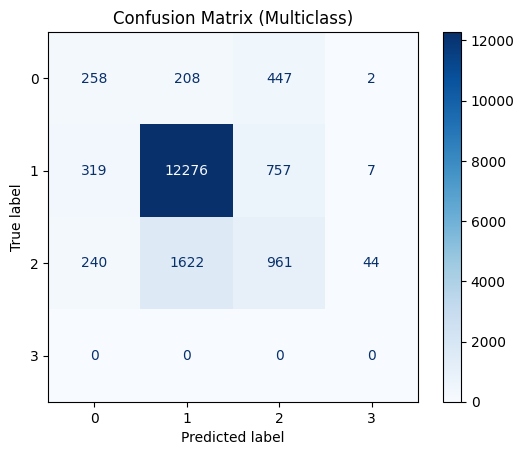

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


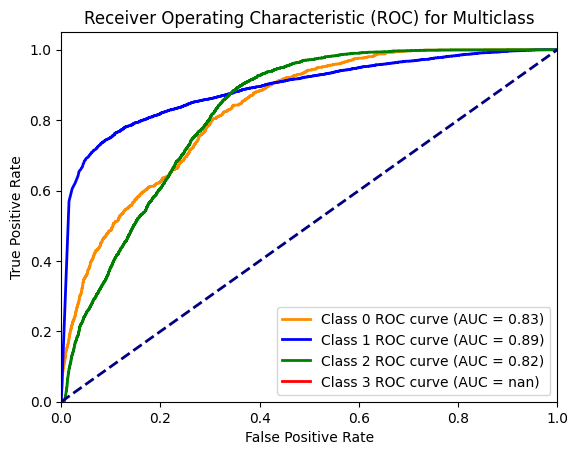

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Assuming predicted_probabilities is a list of lists where each sublist contains probabilities for each class
# Convert probabilities to discrete class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix using the true labels and the predicted class labels
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Optionally, display the confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()

plot_roc_curve(true_labels, predicted_probabilities)

In [ ]:
# SIZE = 256  # Define the size to which images will be resized

def preprocess_images(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    # img = cv2.resize(img, (size, size))         # Resize image
    img = img.astype('float32') / 255.0         # Normalize to [0, 1]
    return img


def downsample_image(img, scale=2):
    # Downsample the image by the scale factor
    low_res = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
    # Upsample back to the original size to simulate low-res appearance
    low_res = cv2.resize(low_res, (img.shape[1], img.shape[0]))
    return low_res


In [ ]:
import numpy as np

# Define the mapping
label_mapping = {
    0: 0,  # Class 1 remains the same
    1: 3,  # Class 2 becomes Class 4
    2: 1,  # Class 3 becomes Class 2
    3: 2   # Class 4 becomes Class 3
}

# Apply the mapping
test_labels_list = np.array([label_mapping[label] for label in test_labels_list])


# Run classifier on low-res and high-res images


In [ ]:
import random
import torch
import torchvision.transforms as transforms
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import os
import torchvision.models as models
from torch import nn
import matplotlib.pyplot as plt
import cv2

random.seed(42)
np.random.seed(42)

# Load pre-trained networks
sr_model = load_model('/content/drive/My Drive/Colab Notebooks/sr_model_final.h5')

# Load MobileNetV2 model
classifier_model = models.mobilenet_v2()  # Load without pre-trained weights
in_features = classifier_model.classifier[1].in_features # take the input from the original last layer

# Replace the last layer of the classifier with a new one for 4 output classes
classifier_model.classifier[1] = nn.Linear(in_features, 4)

# Load the saved model weights
classifier_model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/epoch18.pth", map_location=torch.device('cpu')))

# Set the model to evaluation mode
classifier_model.eval()

# Define transformation for PyTorch classifier
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to model input size if needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



def process_images_by_class(paths, sr_model, classifier_model):
    """
    Processes images by iterating through a PyTorch dataset.

    Args:
        dataset (torch Dataset): Dataset containing images and labels.
        sr_model: The preloaded super-resolution model.
        classifier_model: The preloaded classifier model.

    Returns:
        tuple: Predictions on low-resolution images, super-resolved images, and ground truth labels.
    """
    predictions_low_res_probs = []  # Changed to store probabilities
    predictions_sr_probs = []  # Changed to store probabilities

    for path in paths:  # Iterate through dataset
        # Convert image tensor to NumPy array and transpose channels to HxWxC
        img = preprocess_images(path)

        # --- Low-resolution classification ---
        low_res_image = downsample_image(img)
        low_res_image = (low_res_image * 255).astype(np.uint8)

        # Prepare input for classifier
        input_tensor = transform(Image.fromarray(low_res_image)).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            pred_low_res_probs = classifier_model(input_tensor).softmax(dim=1).squeeze().cpu().numpy()  # Keep probabilities
        predictions_low_res_probs.append(pred_low_res_probs)

        # --- Super-resolution and classification ---
        low_res_array = np.array(low_res_image) / 255.0  # Normalize to [0, 1]
        low_res_array = np.expand_dims(low_res_array, axis=0)  # Add batch dimension
        sr_image_array = sr_model.predict(low_res_array, verbose=0)[0]  # Remove batch dimension

        # Convert NumPy array to PIL image before applying transformation
        sr_image = Image.fromarray((sr_image_array * 255).astype('uint8'))  # Convert back to PIL image

        # Now apply the transformation on the PIL image (SR image)
        input_tensor_sr = transform(sr_image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            pred_sr_probs = classifier_model(input_tensor_sr).softmax(dim=1).squeeze().cpu().numpy()  # Keep probabilities
        predictions_sr_probs.append(pred_sr_probs)

    return predictions_low_res_probs, predictions_sr_probs




# Call the function
from torch.utils.data import Subset

indices = list(range(10))  # First 10 indices
test_subset = Subset(test_dataset, indices)

predictions_low_res, predictions_sr = process_images_by_class(test_files, sr_model, classifier_model)

# Print or analyze results
print(f"Low-resolution predictions: {predictions_low_res}")
print(f"Super-resolution predictions: {predictions_sr}")
print(f"Ground truths: {test_labels_list}")


<ipython-input-20-421b7575cd32>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier_model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/epoch1

Streaming output truncated to the last 5000 lines.
      dtype=float32), array([1.5811163e-11, 9.9930143e-01, 6.9859379e-04, 1.5607879e-09],
      dtype=float32), array([2.2278801e-09, 9.9694258e-01, 3.0573967e-03, 3.4865398e-08],
      dtype=float32), array([4.5568763e-10, 9.8503071e-01, 1.4969344e-02, 3.7786734e-08],
      dtype=float32), array([6.0669336e-06, 9.9823523e-01, 1.7493911e-03, 9.2267210e-06],
      dtype=float32), array([4.7079229e-10, 7.5279525e-04, 9.9924719e-01, 2.0313162e-10],
      dtype=float32), array([7.9389054e-08, 9.9699116e-01, 3.0086401e-03, 1.1044154e-07],
      dtype=float32), array([5.4600878e-06, 9.8764312e-01, 1.2349113e-02, 2.3293776e-06],
      dtype=float32), array([1.2541360e-08, 3.8541639e-01, 6.1458164e-01, 2.0118325e-06],
      dtype=float32), array([8.7368619e-11, 9.9884856e-01, 1.1513886e-03, 2.8938252e-09],
      dtype=float32), array([4.1519710e-05, 1.3754599e-01, 8.6240977e-01, 2.7806154e-06],
      dtype=float32), array([1.1042710e-05, 9.233


Confusion Matrix (Low Res):
                    Mild Dementia  Non-Demented  Very Mild Dementia
Mild Dementia                  79           498                 338
Non-Demented                   59         13172                 616
Very Mild Dementia              9          1774                1023


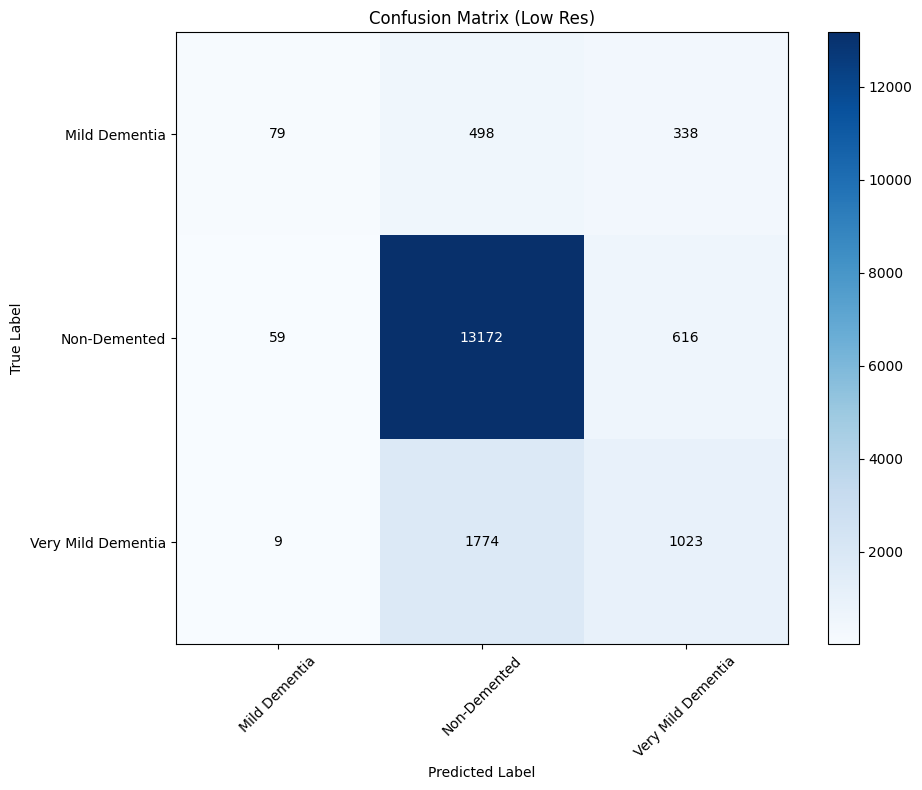


Confusion Matrix (SR):
                    Mild Dementia  Non-Demented  Very Mild Dementia
Mild Dementia                   0           197                 718
Non-Demented                    0         12179                1668
Very Mild Dementia              1           993                1812


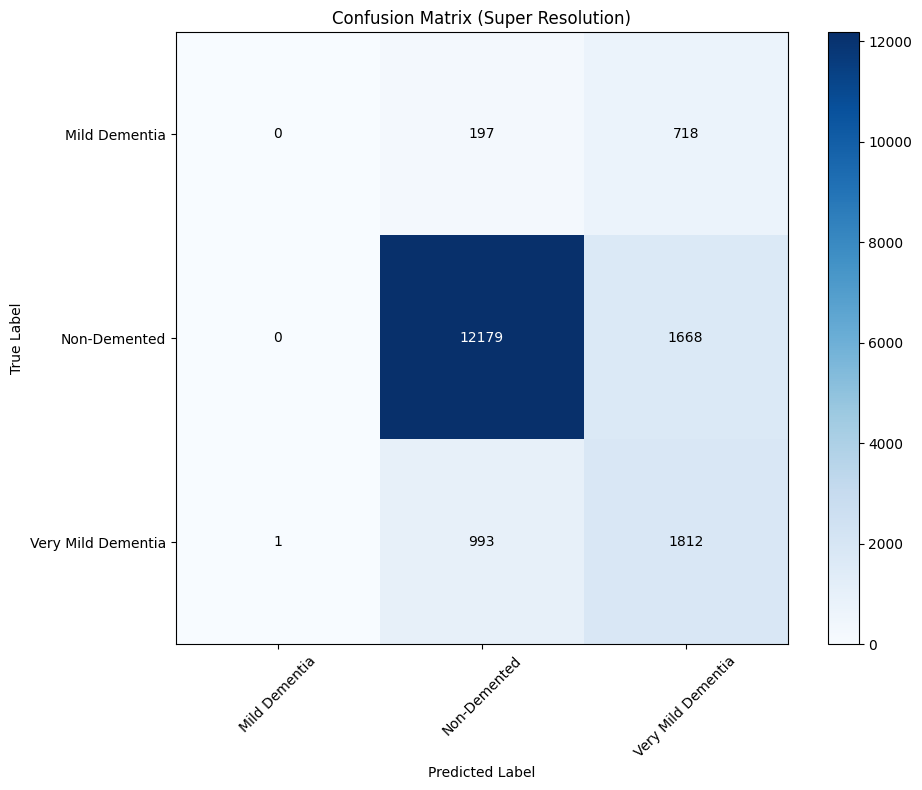


Metrics (Low Res):


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def evaluate_predictions(predictions_low_res, predictions_sr, true_labels, class_names=None):
    # (Existing code...)

    # Calculate confusion matrices
    cm_low_res = confusion_matrix(true_labels, predictions_low_res)
    cm_sr = confusion_matrix(true_labels, predictions_sr)

    # Calculate F1 scores
    f1_low_res = f1_score(true_labels, predictions_low_res, average='weighted')
    f1_sr = f1_score(true_labels, predictions_sr, average='weighted')

    def calculate_metrics(cm):
        """
        Calculates accuracy, sensitivity, specificity, and precision from a confusion matrix.
        """
        # (Existing code for metric calculation...)

    metrics_low_res = calculate_metrics(cm_low_res)
    metrics_sr = calculate_metrics(cm_sr)

    results = {
        "Confusion Matrix (Low Res)": cm_low_res,
        "Confusion Matrix (SR)": cm_sr,
        "F1 Score (Low Res)": f1_low_res,
        "F1 Score (SR)": f1_sr,
        "Metrics (Low Res)": metrics_low_res,
        "Metrics (SR)": metrics_sr
    }

    def plot_confusion_matrix(cm, title, class_names):
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()

        # Add numbers to the heatmap
        threshold = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                color = "white" if cm[i, j] > threshold else "black"
                plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color=color)

        if class_names:
            plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
            plt.yticks(np.arange(len(class_names)), class_names)

        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()


    if class_names:
        print("\nConfusion Matrix (Low Res):")
        print(pd.DataFrame(cm_low_res, index=class_names, columns=class_names))
        plot_confusion_matrix(cm_low_res, "Confusion Matrix (Low Res)", class_names)

        print("\nConfusion Matrix (SR):")
        print(pd.DataFrame(cm_sr, index=class_names, columns=class_names))
        plot_confusion_matrix(cm_sr, "Confusion Matrix (Super Resolution)", class_names)

    return results  # <--- Add this line to return the dictionary


class_names = ['Mild Dementia','Non-Demented', 'Very Mild Dementia']

results = evaluate_predictions(predictions_low_res, predictions_sr, test_labels_list, class_names)

# Print metrics
print("\nMetrics (Low Res):")
for key, value in results["Metrics (Low Res)"].items():
    print(f"{key}: {value}")

print("\nMetrics (SR):")
for key, value in results["Metrics (SR)"].items():
    print(f"{key}: {value}")

# Print F1 scores
print(f"\nF1 Score (Low Res): {results['F1 Score (Low Res)']}")
print(f"F1 Score (SR): {results['F1 Score (SR)']}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


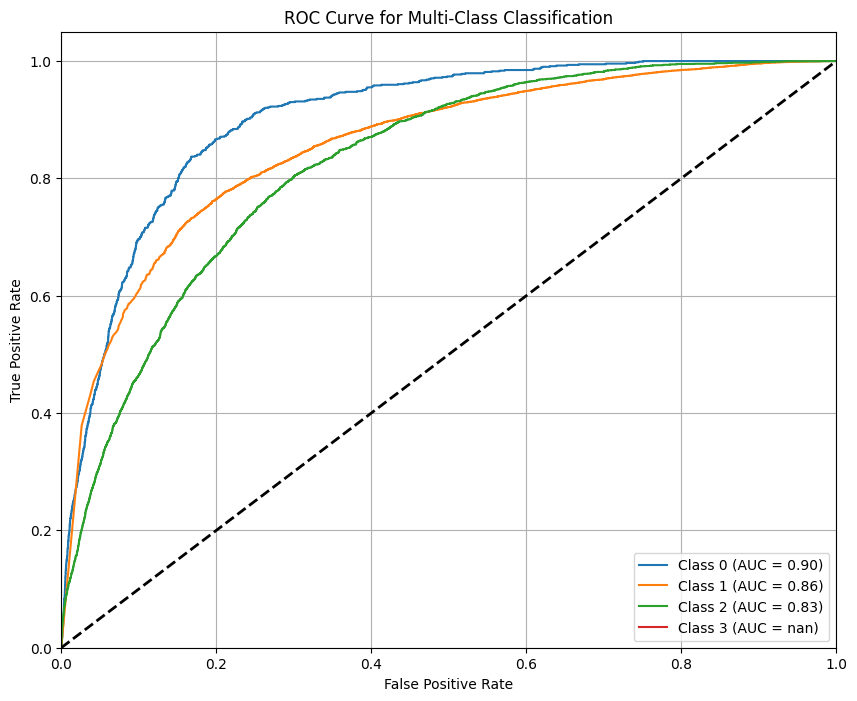

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


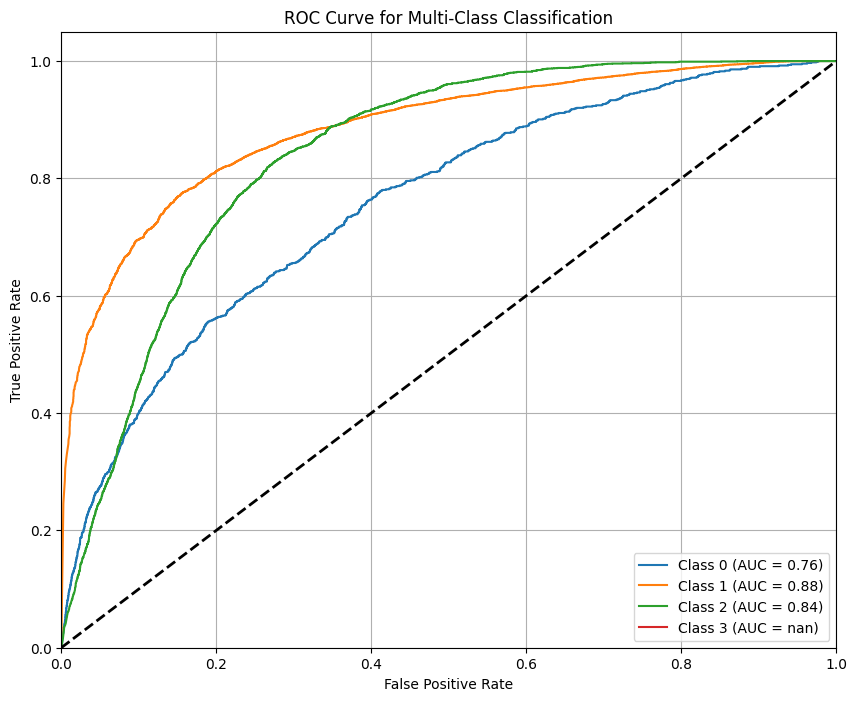

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_score, n_classes):
    """
    Plots the ROC curve for a multi-class classification problem.

    Parameters:
    - y_true: True labels (one-hot encoded or binary format).
    - y_score: Predicted probabilities for each class.
    - n_classes: Number of classes in the dataset.
    """
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
    y_score = np.array(y_score)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"Class {i} (AUC = {roc_auc[i]:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_multiclass_roc(test_labels_list, predictions_low_res, n_classes=4)
plot_multiclass_roc(test_labels_list, predictions_sr, n_classes=4)